In [149]:
# import packages
import cftime
import gc
import glob
import sys

import cartopy as cy
import cartopy.crs as ccrs
import cmcrameri.cm as ccm
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy.stats import norm
import xarray as xr
import geopandas as gpd
from params import savepath, homedir, allnames, datadir

plt.style.use('science.mplstyle')
mpl.rcParams['axes.linewidth'] = 1

states = gpd.read_file('../data/ne_110m_admin_1_states_provinces.shp')

In [3]:
coords1 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d01')
coords2 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d02')
coords4 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d04')
coords3 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d03')
coords_dict = {'d01': coords1,
          'd02': coords2,
          'd03': coords3,
          'd04': coords4}

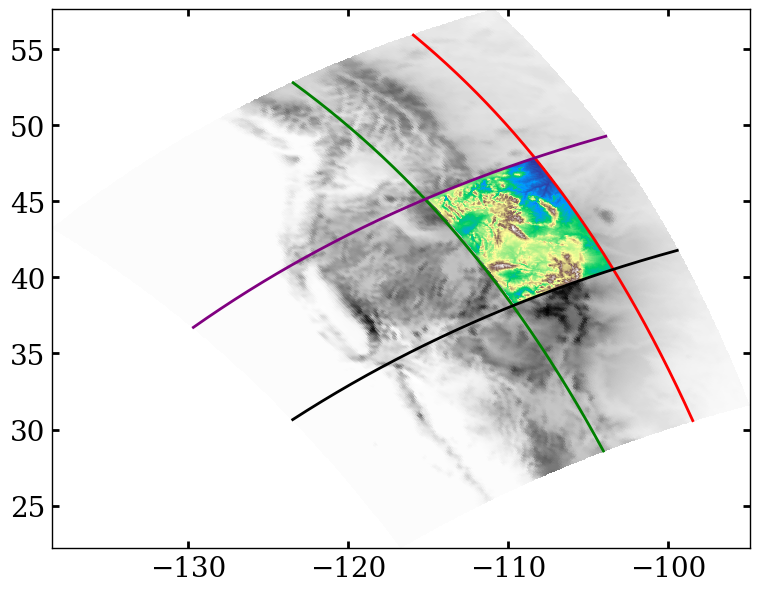

In [148]:
fig,ax = plt.subplots()
left = 165
right = 230
bottom = 130
top = 227
color = 'red'
ax.pcolormesh(coords2['XLONG'][0], coords2['XLAT'][0], coords2['HGT'][0], cmap = 'Greys')
ax.plot(coords2['XLONG'][0,:,right], coords2['XLAT'][0,:,right], color =  'red')
ax.plot(coords2['XLONG'][0,:,left], coords2['XLAT'][0,:,left], color =  'green')
ax.plot(coords2['XLONG'][0,bottom,:], coords2['XLAT'][0,bottom,:], color = 'black')
ax.plot(coords2['XLONG'][0,top,:], coords2['XLAT'][0,top,:], color = 'purple')
ax.pcolormesh(coords4['XLONG'][0], coords4['XLAT'][0], coords4['HGT'][0], cmap = 'terrain')

plt.show()

In [4]:
datadir = '/glade/campaign/uwyo/wyom0112/berkeley'
domain = 'd02'
bc = 'BC'
sidename = 'wind'
coords = coords_dict[domain]
sidemasks = xr.open_dataset(f'masks_{domain}_sn.nc')
gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',]

In [27]:
%%time 
# need to re-run this!! july 11 2023, because previous version just did one. probably takes about 1 hours
date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"

for domain in['d02']:
    for var in ['snow', 'prec', 't2']:
        alldata = []
        for gcm in gcms:
            data = xr.open_dataset(f'{datadir}/{var}_{gcm}_{domain}_{bc}.nc').sortby('time')
            alldata.append(data.resample(time = '1M').mean(dim='time') - data.sel(time = slice(date_start_hist, date_end_hist)).mean(dim = 'time'))
        mean_anom = xr.concat(alldata, dim='gcm').mean(dim = 'gcm')
        mean_anom.to_netcdf(f'{var}_{domain}_{bc}_meananom_annual.nc')

CPU times: user 8min 30s, sys: 16min 39s, total: 25min 9s
Wall time: 1h 27min 52s


In [44]:
%%time 
# need to re-run this!! july 11 2023, because previous version just did one. probably takes about 1 hours
date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"

for domain in['d01']:
    for var in ['prec', 't2', 'snow']:
        alldata = []
        for gcm in gcms:
            data = xr.open_dataset(f'{datadir}/{var}_{gcm}_{domain}_{bc}.nc').sortby('time')
            alldata.append(data.resample(time = '1M').mean(dim='time'))
        mean_anom = xr.concat(alldata, dim='gcm').mean(dim = 'gcm')
        mean_anom.to_netcdf(f'{var}_{domain}_{bc}_monthly.nc')

CPU times: user 1min 4s, sys: 15.7 s, total: 1min 20s
Wall time: 1min 37s


In [6]:
%%time
date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"
ts = {}
sidenames = ['wind', 'lee']
domains = ['d01','d02'] ## 25 seconds for d1 per side
for domain in ['d02']:
    ts[domain] = {}
    sidemasks = xr.open_dataset(f'masks_{domain}_sn.nc')
    for sidename in sidenames:
        ts[domain][sidename] = {}
        emask = xr.open_dataset(f'e1500_{domain}.nc')
        emask_values = emask['HGT'].data
        smask_values = sidemasks.sel(side = sidename).basin_mask.values
        mask = (emask_values & smask_values)
        for gcm in gcms[0:1]:
            snowdata = xr.open_dataset(f'{datadir}/snow_{gcm}_{domain}_{bc}.nc').sortby('time')
            precdata = xr.open_dataset(f'{datadir}/prec_{gcm}_{domain}_{bc}.nc').sortby('time')
            t2data = xr.open_dataset(f'{datadir}/t2_{model}_{domain}_{bc}.nc').sortby('time')
            a_snow = snowdata.resample(time='5AS').mean(dim='time') - snowdata.sel(time = slice(date_start_hist, date_end_hist)).mean(dim = 'time')
            a_snow = a_snow.where(mask)['snow']
            t_snow = a_snow.mean(dim = 'lat2d').mean(dim = 'lon2d')
            a_prec = precdata.resample(time='5AS').mean(dim='time')  - precdata.sel(time = slice(date_start_hist, date_end_hist)).mean(dim = 'time')
            a_prec = a_prec.where(mask)['prec']
            t_prec = a_prec.mean(dim = 'lat2d').mean(dim = 'lon2d')
            a_t2 = t2data.resample(time='5AS').mean(dim='time')  - t2data.sel(time = slice(date_start_hist, date_end_hist)).mean(dim = 'time')
            a_t2 = a_t2.where(mask)['t2']
            t_t2 = a_t2.mean(dim = 'lat2d').mean(dim = 'lon2d')
            ts[domain][sidename][gcm] = {'snow':t_snow,
                      'prec':t_prec,
                      't2':t_t2}


KeyboardInterrupt



In [5]:
# snowdata = xr.open_mfdataset(glob.glob(f'{datadir}/snow_*_{domain}_{bc}.nc'), combine = 'nested', concat_dim = 'gcm')
domain = 'd02'
bc = 'BC'
precdata = xr.open_mfdataset(glob.glob(f'{datadir}/prec_*_{domain}_{bc}.nc'), combine = 'nested', concat_dim = 'time')
t2data = xr.open_mfdataset(glob.glob(f'{datadir}/t2_*_{domain}_{bc}.nc'), combine = 'nested', concat_dim = 'time')
emask = xr.open_dataset(f'e1500_{domain}.nc')
emask_values = emask['HGT'].data

In [6]:
%time
snowdata = []
fns = glob.glob(f'{datadir}/snow_*_{domain}_{bc}.nc')
for fn in fns:
    tmp = xr.open_dataset(fns[0])
    tmp2 = tmp.sortby('time')
    snowdata.append(tmp2)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [9]:
snowdata = xr.concat(snowdata, dim = 'gcm') ## takes a little while... maybe one hour? need to save the ouputs eventually so i dont have to do this again. why are the snow data not good?

In [13]:
snowdata.to_netcdf(f'{datadir}/snow_d02_BC_sorted.nc')

In [7]:
snowdata = xr.open_dataset(f'{datadir}/snow_d02_BC_sorted.nc')

In [14]:
fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/swei_max_*{domain}_{bc}*') 
allswei = xr.open_mfdataset(fns, combine='nested', concat_dim='gcm')
allswei_mean = allswei.mean(dim = 'gcm')


In [5]:
domain = 'd03' ## 03 is california, 04 is wyoming
bc = 'BC'
fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/snow_*{domain}_{bc}.nc') 
snowdata = []
for fn in fns[0:1]:
    snow = xr.open_dataset(fn)
    snowmax = snow.groupby(snow.time.dt.year).max()
    snowdata.append(snowmax)
snowdata_d03_all = xr.concat(snowdata, dim = 'gcm')
snowdata_d03_mean = snowdata_all.mean(dim = 'gcm')

In [144]:
params = {'vars': ['prec','t2','snow'],
          'states' : ['CA', 'WY'],
          'res': ['45','9','3']}
res_domain = {'3': ['d03','d04'],
               '9' :['d02'],
               '45':['d01']}
domain_state = {'d01':['CA','WY'],
                'd02':['CA','WY'],
                'd03':['CA'],
                'd04':['WY'],}
boundaries = {'d01':{'CA': [43,60,35,68],
                     'WY': [68,81,43,63]},
              'd02':{'CA': [44,125,87,251],
                     'WY': [165,230,130,227]},
              'd03':{'CA': [0,-1,0,-1]},
              'd04':{'WY': [0,-1,0,-1]}}
state_res_domain = {'CA': {'45':'d01',
                            '9': 'd02',
                            '3':'d03'},
                     'WY': {'45':'d01',
                            '9': 'd02',
                            '3':'d04'},}

gcm = 'ec-earth3-veg'
bc = 'BC'
## make the dictionary: 
alldata = {}
for var in params['vars']: 
    alldata[var] = {}
    for state in params['states']:
        alldata[var][state] = {}
        for res in params['res']:
            alldata[var][state][res] = {}

## fill raw data
for var in params['vars']: 
    for state in params['states']:
        for res in params['res']:
            domain = state_res_domain[state][res]
            alldata[var][state][res]['raw'] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_{gcm}_{domain}_{bc}.nc')
    

In [ ]:
## annual max should take 2 mins
for var in params['vars']: 
    for state in params['states']:
        for res in params['res']:
            alldata[var][state][res]['annual_max'] = alldata[var][state][res]['raw'].resample(time = '1AS').max()
    


In [ ]:
## clip
for var in params['vars']: 
    for state in params['states']:
        for res in params['res']:
            left, right, bottom, top = boundaries[domain][state]
            alldata[var][state][res]['annual_max'] =  alldata[var][state][res]['annual_max'].sel(lat2d = slice(bottom, top),
                                                                   lon2d = slice(left, right))


In [ ]:
## clip
## now plot it 
ws = 20
res = {'d01':'45','d02':'9', 'd03':'3','d04':'3'}
fig,axs = plt.subplots(2,3, figsize = (7,10))
for i,var in enumerate(params['vars']): 
    for j, state in enumerate(params['states']):
        ax = axs[i,j]
        for res in params['res']:
        data = alldata[var][state][res]['annual_max'].mean(dim = 'lat2d').mean(dim = 'lon2d')['snow']
            if data is not None:
                ax.plot(data.time.dt.year, data['snow'], linestyle = ':', alpha = 0.4)
                rolling_yearmean = pd.DataFrame(data.time.dt.year).rolling(window = ws).max()
                rolling_mean = pd.DataFrame(data['snow']).rolling(window=ws).mean()
                ax.plot(rolling_yearmean,rolling_mean, label = f'{res[domain]}-km')
                ax.hlines(np.nanmean(data['snow'][0:20]), 1980, 2100, linewidth = 1)

        ax.set_ylabel('SWE [mm]')
        #ax.set_ylim((-30, 180))
    axs[0].legend(loc = 'upper right')
    axs[0].text(1980, 140, 'CA')
    axs[1].text(1980, 200, 'WY')
    plt.show()


In [8]:
snow_d04 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d04_BC.nc')
snow_d03 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d03_BC.nc')
snow_d02_veg = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d02_BC.nc')
snow_d01_veg = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/snow_ec-earth3-veg_d01_BC.nc')

In [43]:
snowdata_d04_annualmax = snow_d04.resample(time = '1AS').max()
snowdata_d03_annualmax = snow_d03.resample(time = '1AS').max()
snowdata_d02_annualmax = snow_d02_veg.resample(time = '1AS').max()
snowdata_d01_annualmax = snow_d01_veg.resample(time = '1AS').max()
snowdata_d04_annualmax_CA = None
snowdata_d03_annualmax_WY = None
snowdata_d04_annualmax_WY = snowdata_d04_annualmax
snowdata_d03_annualmax_CA = snowdata_d03_annualmax


In [103]:
%%time
snowdata_d04_annualsum = snow_d04.resample(time = '1AS').sum()
snowdata_d03_annualsum = snow_d03.resample(time = '1AS').sum()
snowdata_d02_annualsum = snow_d02_veg.resample(time = '1AS').sum()
snowdata_d01_annualsum = snow_d01_veg.resample(time = '1AS').sum()
snowdata_d04_annualsum_CA = None
snowdata_d03_annualsum_WY = None
snowdata_d04_annualsum_WY = snowdata_d04_annualsum
snowdata_d03_annualsum_CA = snowdata_d03_annualsum

CPU times: user 27.6 s, sys: 1min 5s, total: 1min 32s
Wall time: 2min 27s


In [29]:
## clip d02 and d01 to the california and wyoming regions:
left, right, bottom, top = boundaries['d02']['CA']
snowdata_d02_annualmax_CA = snowdata_d02_annualmax.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))
left, right, bottom, top = boundaries['d02']['WY']
snowdata_d02_annualmax_WY = snowdata_d02_annualmax.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))
left, right, bottom, top = boundaries['d01']['CA']

snowdata_d01_annualmax_CA = snowdata_d01_annualmax.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))
left, right, bottom, top = boundaries['d01']['WY']

snowdata_d01_annualmax_WY =snowdata_d01_annualmax.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))


In [104]:
## clip d02 and d01 to the california and wyoming regions:
left, right, bottom, top = boundaries['d02']['CA']
snowdata_d02_annualsum_CA = snowdata_d02_annualsum.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))
left, right, bottom, top = boundaries['d02']['WY']
snowdata_d02_annualsum_WY = snowdata_d02_annualsum.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))
left, right, bottom, top = boundaries['d01']['CA']

snowdata_d01_annualsum_CA = snowdata_d01_annualsum.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))
left, right, bottom, top = boundaries['d01']['WY']

snowdata_d01_annualsum_WY =snowdata_d01_annualsum.sel(lat2d = slice(bottom, top),
                                                       lon2d = slice(left, right))


In [46]:
snowdata = {'CA':{'d01':snowdata_d01_annualmax_CA,
                 'd02':snowdata_d02_annualmax_CA,
                 'd03':snowdata_d03_annualmax_CA,
                 'd04': None},
            'WY':{'d01':snowdata_d01_annualmax_WY,
                 'd02':snowdata_d02_annualmax_WY,
                 'd03':None,
                 'd04': snowdata_d04_annualmax_WY},
    
           }

In [105]:
snowdata_sum = {'CA':{'d01':snowdata_d01_annualsum_CA,
                 'd02':snowdata_d02_annualsum_CA,
                 'd03':snowdata_d03_annualsum_CA,
                 'd04': None},
            'WY':{'d01':snowdata_d01_annualsum_WY,
                 'd02':snowdata_d02_annualsum_WY,
                 'd03':None,
                 'd04': snowdata_d04_annualsum_WY},
    
           }

In [128]:
## Make geographic  that only include land areas
geog_means = {}
states = ['CA','WY']
domains =  ['d01', 'd02','d03','d04']
for state in states:
    geog_means[state] = {}
    for domain in domains:
        tmp = snowdata[state][domain]
        if tmp is not None:
            tmp2 = tmp.copy()
            mask = np.nanmean(tmp2['snow'][0:10,:,:], axis = (0)) > 1
            geog_means[state][domain] = tmp2.where(mask).mean(dim = 'lat2d').mean(dim = 'lon2d')
            #geog_means[state][domain] = tmp2.mean(dim = 'lat2d').mean(dim = 'lon2d')

        else:
            geog_means[state][domain] = None


In [114]:
## Make geographic  that only include land areas
geog_means_sum = {}
states = ['CA','WY']
domains =  ['d01', 'd02','d03','d04']
for state in states:
    geog_means_sum[state] = {}
    for domain in domains:
        tmp = snowdata_sum[state][domain]
        if tmp is not None:
            tmp2 = tmp.copy()
            mask = np.nanmean(tmp2['snow'][0:10,:,:], axis = (0)) > 1
            geog_means_sum[state][domain] = tmp2.where(mask).mean(dim = 'lat2d').mean(dim = 'lon2d')
            #geog_means_sum[state][domain] = tmp2.mean(dim = 'lat2d').mean(dim = 'lon2d')

        else:
            geog_means_sum[state][domain] = None


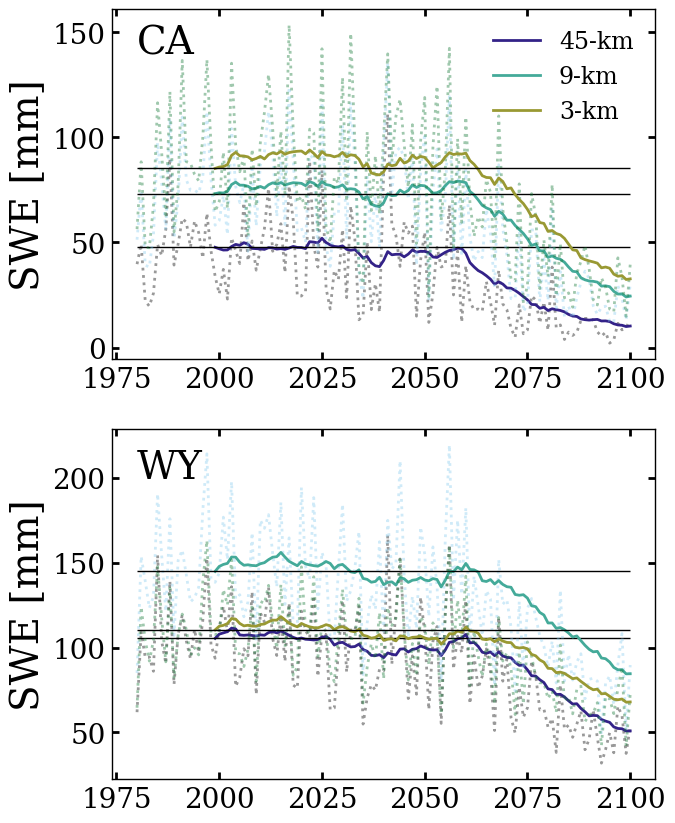

In [131]:
ws = 20
res = {'d01':'45','d02':'9', 'd03':'3','d04':'3'}
fig,axs = plt.subplots(2,1, figsize = (7,10))
for i, state in enumerate(states):
    ax = axs[i]
    for domain in domains:
        data = geog_means[state][domain]
        if data is not None:
            ax.plot(data.time.dt.year, data['snow'], linestyle = ':', alpha = 0.4)
            rolling_yearmean = pd.DataFrame(data.time.dt.year).rolling(window = ws).max()
            rolling_mean = pd.DataFrame(data['snow']).rolling(window=ws).mean()
            ax.plot(rolling_yearmean,rolling_mean, label = f'{res[domain]}-km')
            ax.hlines(np.nanmean(data['snow'][0:20]), 1980, 2100, linewidth = 1)

    ax.set_ylabel('SWE [mm]')
    #ax.set_ylim((-30, 180))
axs[0].legend(loc = 'upper right')
axs[0].text(1980, 140, 'CA')
axs[1].text(1980, 200, 'WY')
plt.show()

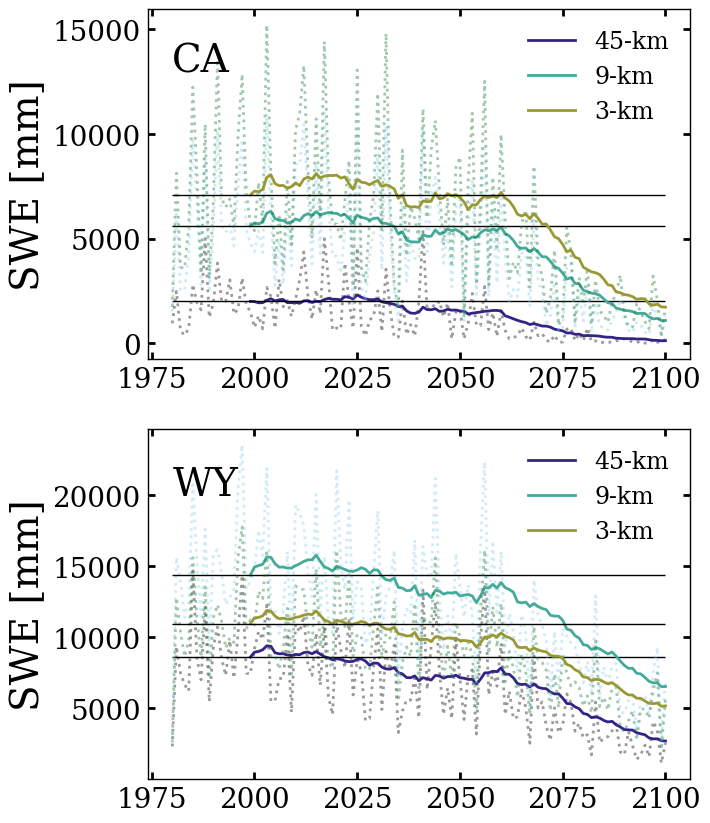

In [132]:
ws = 20
res = {'d01':'45','d02':'9', 'd03':'3','d04':'3'}
fig,axs = plt.subplots(2,1, figsize = (7,10))
for i, state in enumerate(states):
    ax = axs[i]
    for domain in domains:
        data = geog_means_sum[state][domain]
        if data is not None:
            ax.plot(data.time.dt.year, data['snow'], linestyle = ':', alpha = 0.4)
            rolling_yearmean = pd.DataFrame(data.time.dt.year).rolling(window = ws).max()
            rolling_mean = pd.DataFrame(data['snow']).rolling(window=ws).mean()
            ax.plot(rolling_yearmean,rolling_mean, label = f'{res[domain]}-km')
            ax.hlines(np.nanmean(data['snow'][0:20]), 1980, 2100, linewidth = 1)
    ax.set_ylabel('SWE [mm]')
    #ax.set_ylim((-30, 180))
    ax.legend(loc = 'upper right')
axs[0].text(1980, 13000, 'CA')
axs[1].text(1980, 20000, 'WY')
plt.show()

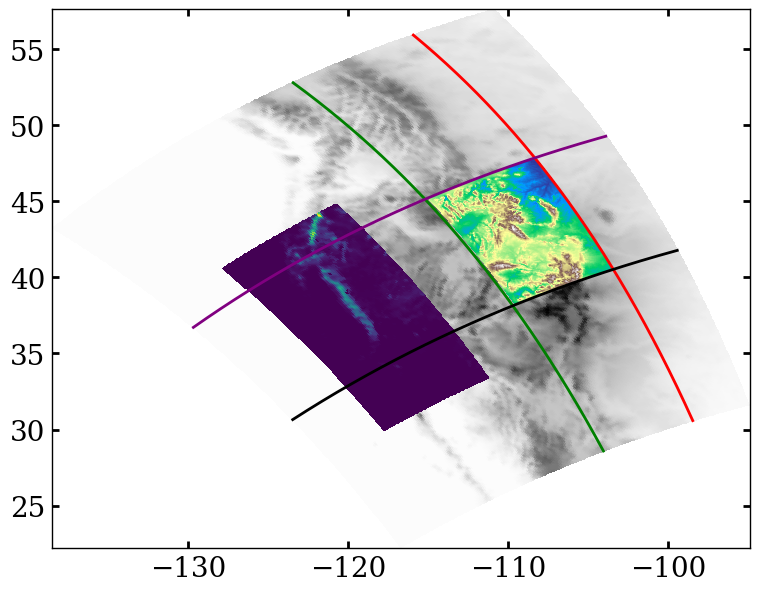

In [28]:
fig,ax = plt.subplots()
left = 165
right = 230
bottom = 130
top = 227
color = 'red'
ax.pcolormesh(coords2['XLONG'][0], coords2['XLAT'][0], coords2['HGT'][0], cmap = 'Greys')
ax.plot(coords2['XLONG'][0,:,right], coords2['XLAT'][0,:,right], color =  'red')
ax.plot(coords2['XLONG'][0,:,left], coords2['XLAT'][0,:,left], color =  'green')
ax.plot(coords2['XLONG'][0,bottom,:], coords2['XLAT'][0,bottom,:], color = 'black')
ax.plot(coords2['XLONG'][0,top,:], coords2['XLAT'][0,top,:], color = 'purple')
ax.pcolormesh(coords4['XLONG'][0], coords4['XLAT'][0], coords4['HGT'][0], cmap = 'terrain')
# ax.pcolormesh(coords1['XLONG'][0,bottom:top,left:right], coords1['XLAT'][0, bottom:top,left:right], coords1['HGT'][0, bottom:top,left:right], cmap = 'Reds')
left = bounds[0]
right = bounds[1]
bottom = bounds[2]
top = bounds[3]

ax.pcolormesh(coords2['XLONG'][0,bottom:top,left:right], coords2['XLAT'][0,bottom:top,left:right], snowdata_d02_annualmax_CA['snow'][0])
plt.show()


In [43]:
snowdata_d03_geogmean = np.nanmean(snowdata_d03_all['snow'], axis = (1,2))

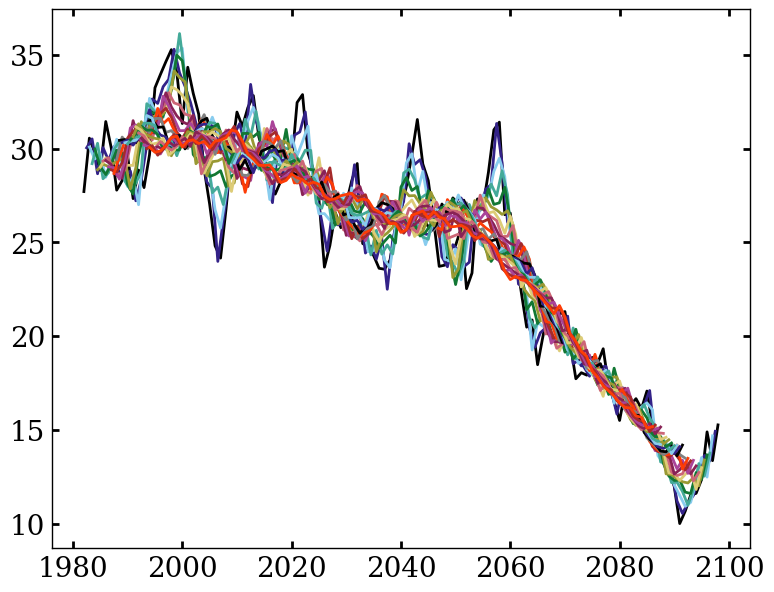

In [73]:
fig,ax = plt.subplots()
for ws in range(5,30):
    rolling_yearmean = pd.DataFrame(snowdata_d03_all.year).rolling(window = ws).mean()
    rolling_mean = pd.DataFrame(np.nanmean(snowdata_d04_all['snow'],axis = (1,2))).rolling(window=ws).mean()
    ax.plot(rolling_yearmean,rolling_mean)
plt.show()

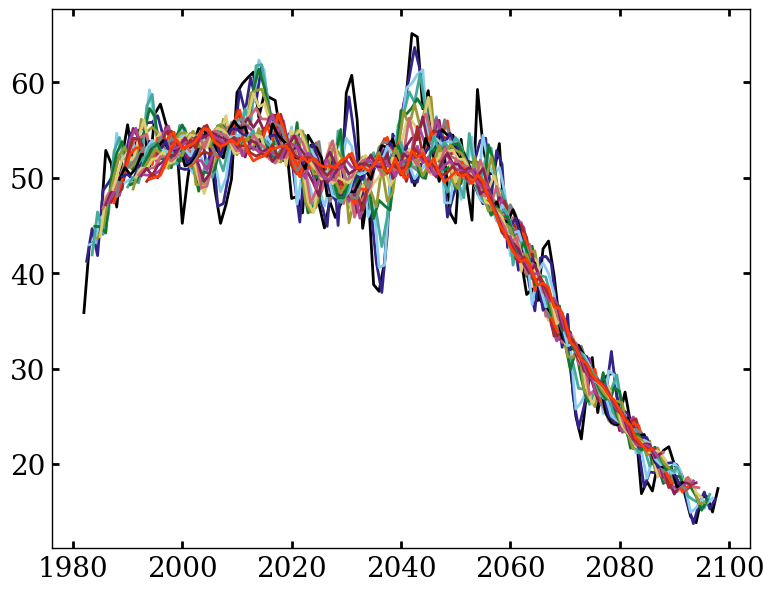

In [65]:
fig,ax = plt.subplots()
for ws in range(5,30):
    rolling_yearmean = pd.DataFrame(snowdata_d03_all.year).rolling(window = ws).mean()
    rolling_mean = pd.DataFrame(snowdata_d03_geogmean).rolling(window=ws).mean()
    ax.plot(rolling_yearmean,rolling_mean)
plt.show()

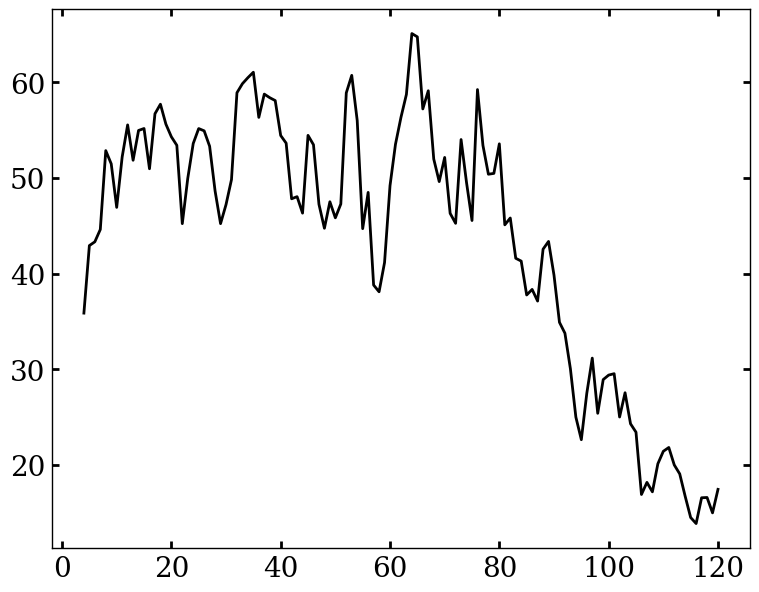

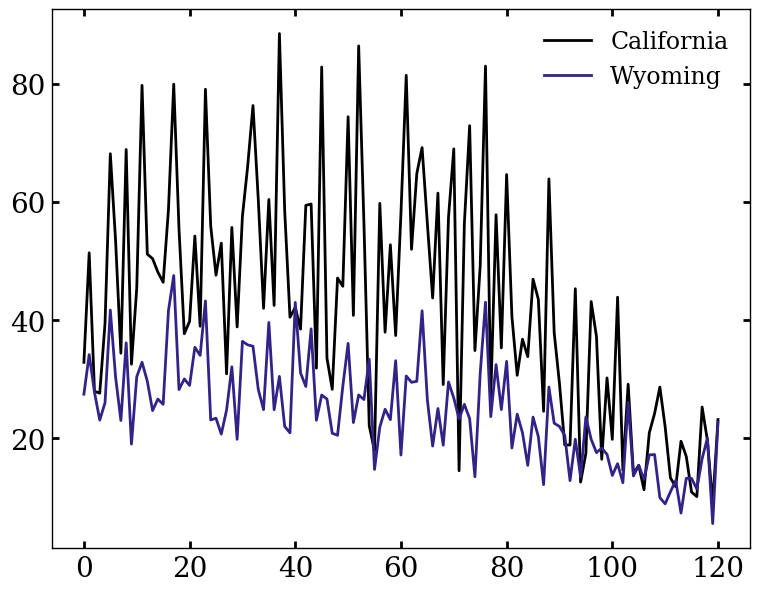

In [27]:
fig,ax = plt.subplots()
ax.plot(np.nanmean(snowdata_all['snow'], axis = (0,2,3)), label = 'California')
ax.plot(np.nanmean(snowdata_d04_all['snow'], axis = (1,2)), label = 'Wyoming')
ax.legend()
plt.show()

In [37]:
plt.plot(np.nanmean(snowdata_all.resample(year = 5).max()['snow'], axis = (0,2,3)))

ValueError: Invalid frequency: 5

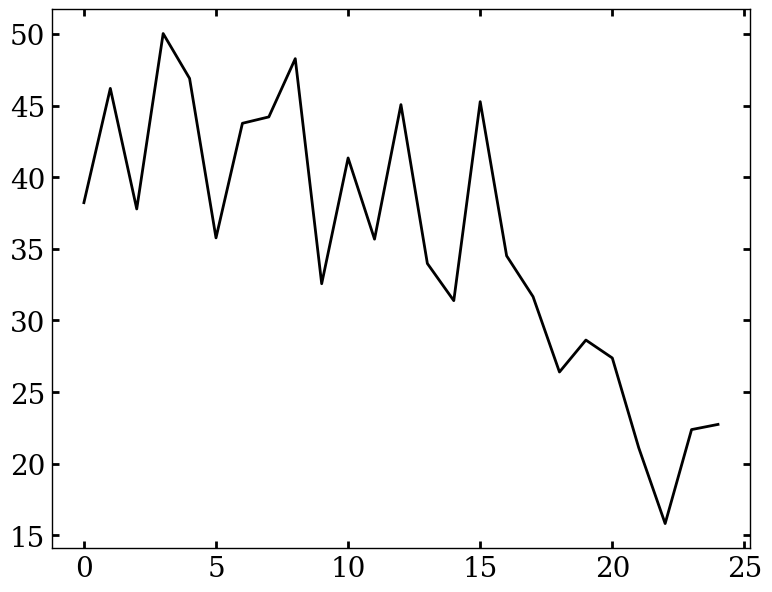

In [34]:
plt.plot(np.nanmean(snowdata_d04_all.resample(time = '5AS').max()['snow'], axis = (1,2)))

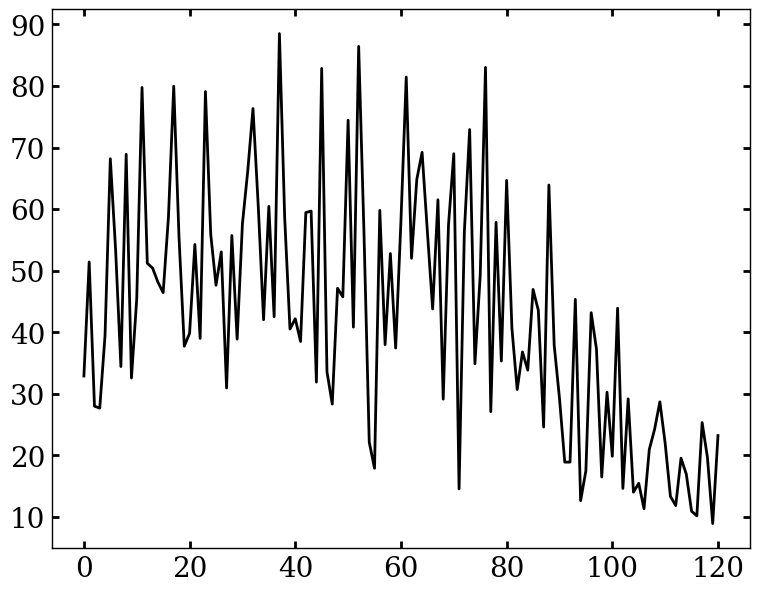

In [15]:
domain = 'd02'
fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/categ*{domain}_{bc}*') 
allcateg = xr.open_mfdataset(fns, combine='nested', concat_dim='gcm')
allcateg_sum = allcateg.sum(dim = 'gcm')

/glade/scratch/mcowherd/ipykernel_176419/3356033057.py:13: RuntimeWarning: Mean of empty slice
  c_t2 = np.nanmean(t2_meananom['t2'].where(mask), axis = (1,2))
/glade/scratch/mcowherd/ipykernel_176419/3356033057.py:14: RuntimeWarning: Mean of empty slice
  c_prec = np.nanmean(prec_meananom['prec'].where(mask), axis = (1,2))
/glade/scratch/mcowherd/ipykernel_176419/3356033057.py:15: RuntimeWarning: Mean of empty slice
  c_snow = np.nanmean(snow_meananom['snow'].where(mask), axis = (1,2))


ValueError: s must be a scalar, or float array-like with the same size as x and y

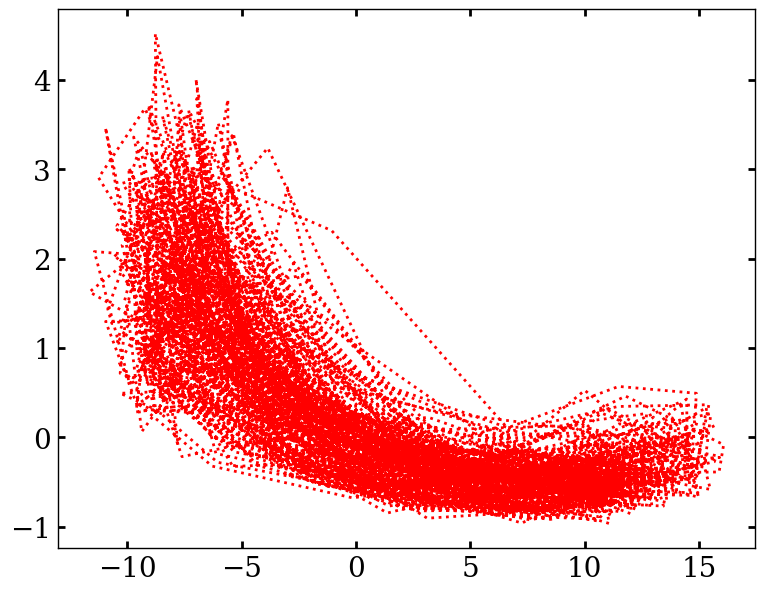

In [34]:
years = range(1980,2101, 5)
t2_meananom = xr.open_dataset(f't2_{domain}_{bc}_meananom_annual.nc')
prec_meananom = xr.open_dataset(f'prec_{domain}_{bc}_meananom_annual.nc')
snow_meananom = xr.open_dataset(f'snow_{domain}_{bc}_meananom_annual.nc')
emask = xr.open_dataset(f'e1500_{domain}.nc')
emask_values = emask['HGT'].data
fig,ax = plt.subplots()

colors = {'lee': 'red', 'wind': 'black'}
for sidename in ['lee', 'wind']:
    smask_values = sidemasks.sel(side = sidename).basin_mask.values
    mask = (emask_values & smask_values)
    c_t2 = np.nanmean(t2_meananom['t2'].where(mask), axis = (1,2))
    c_prec = np.nanmean(prec_meananom['prec'].where(mask), axis = (1,2))
    c_snow = np.nanmean(snow_meananom['snow'].where(mask), axis = (1,2))
    #c_swei = np.nanmean(allswei_mean['swei'].where(mask), axis = (1,2))
    tmp = allcateg_sum['pr_cond'].where(mask).load()
    tmp2 = np.nanmean(tmp, axis= (1,2))
    grouped_tmp = tmp2[0:120].reshape(-1, 5)
    # Calculate the mean for each group
    mean_per_group = np.mean(grouped_tmp, axis=1)

    ax.plot(c_t2[0:-1], c_prec[0:-1], ':', label = f'{domain} {sidename}', color = colors[sidename])
    ax.scatter(c_t2[0:-1],c_prec[0:-1], s = -mean_per_group + np.e)


# Set logarithmic scales on both axes
ax.set_xscale('symlog')
ax.set_yscale('symlog')

# Set the limits of the axes to make them symmetrical around zero
ax.set_xlim([-1e1, 1e1])
ax.set_ylim([-1e1, 1e1])

# Add grid lines at zero on both axes
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Temperature')
ax.set_ylabel('Precipitation')
ax.legend()
plt.show()

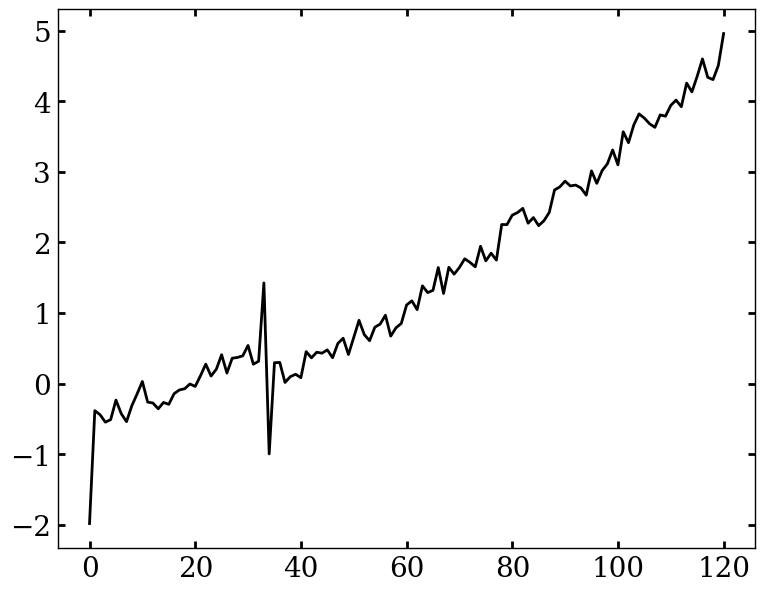

In [44]:
fig,ax = plt.subplots()
ax.plot(np.nanmean(t2_meananom.resample(time = '1AS').mean()['t2'], axis = (1,2)))
plt.show()

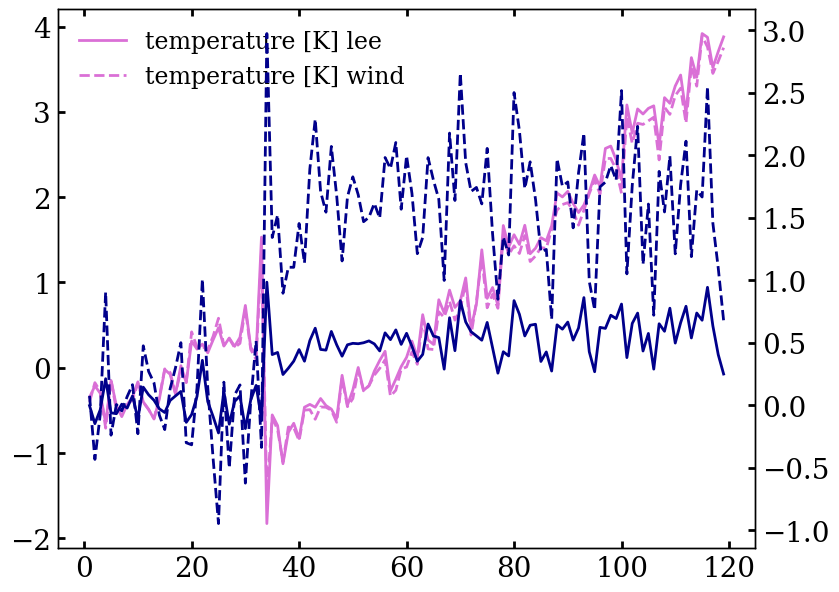

In [46]:
years = range(120) #range(1981, 2100, 5)
#t2_meananom = xr.open_dataset(f't2_{domain}_{bc}_meananom.nc').resample(time = '1AS').sum(dim = 'time')
#prec_meananom = xr.open_dataset(f'prec_{domain}_{bc}_meananom.nc').resample(time = '1AS').sum(dim = 'time')
#snow_meananom = xr.open_dataset(f'snow_{domain}_{bc}_meananom.nc').resample(time = '1AS').sum(dim = 'time')

t2_mean_ann = t2_meananom.resample(time = '1AS').mean(dim = 'time')
prec_mean_ann = prec_meananom.resample(time = '1AS').mean(dim = 'time')
snow_mean_ann = snow_meananom.resample(time = '1AS').mean(dim = 'time')

emask = xr.open_dataset(f'e1500_{domain}.nc')
emask_values = emask['HGT'].data
style = {'lee': '-',
         'wind': '--',
         'prec': 'darkblue',
         'temp': 'orchid'}

fig,ax = plt.subplots()
ax2 = ax.twinx()
for sidename in ['lee', 'wind']:
    smask_values = sidemasks.sel(side = sidename).basin_mask.values
    mask = (emask_values & smask_values)
    c_t2 = np.nanmean(t2_mean_ann['t2'].where(mask), axis = (1,2))
    c_prec = np.nanmean(prec_mean_ann['prec'].where(mask), axis = (1,2))
    c_snow = np.nanmean(snow_mean_ann['snow'].where(mask), axis = (1,2))
    c_t2[0] = np.nan
    c_prec[0] = np.nan
    c_snow[0] = np.nan
    #c_t2[33:35] = np.nan
    #c_prec[33:35] = np.nan
    #c_snow[33:35] = np.nan
    ax.plot(years, c_t2[0:-1], linestyle = style[sidename], color = style['temp'], label = f'temperature [K] {sidename}')
    ax2.plot(years, c_prec[0:-1], linestyle = style[sidename],  color = style['prec'], label = f'precipitation [mm/d] {sidename}')
ax.legend()
plt.show()

In [17]:
years = range(120) #range(1981, 2100, 5)
t2_meananom = xr.open_dataset(f't2_{domain}_{bc}_monthly.nc').resample(time = '1AS').sum(dim = 'time')
prec_meananom = xr.open_dataset(f'prec_{domain}_{bc}_monthly.nc').resample(time = '1AS').sum(dim = 'time')
snow_meananom = xr.open_dataset(f'snow_{domain}_{bc}_monthly.nc').resample(time = '1AS').sum(dim = 'time')
emask = xr.open_dataset(f'e1500_{domain}.nc')
emask_values = emask['HGT'].data
style = {'lee': '-',
         'wind': '--',
         'prec': 'darkblue',
         'temp': 'orchid'}

fig,ax = plt.subplots()
ax2 = ax.twinx()
mask = (emask_values) #  & smask_values)
c_t2 = np.nanmean(t2_meananom['t2'].where(mask), axis = (1,2))
c_prec = np.nanmean(prec_meananom['prec'].where(mask), axis = (1,2))
c_snow = np.nanmean(snow_meananom['snow'].where(mask), axis = (1,2))
c_t2[0] = np.nan
c_prec[0] = np.nan
c_snow[0] = np.nan
c_t2[33:35] = np.nan
c_prec[33:35] = np.nan
c_snow[33:35] = np.nan
ax.plot(years, c_t2[0:-1], color = style['temp'], label = f'temperature [K] ')
ax2.plot(years, c_prec[0:-1],  color = style['prec'], label = f'precipitation [mm/d]')
ax.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/u/home/mcowherd/snow_drought/downscaling/t2_d02_BC_monthly.nc'

/glade/scratch/mcowherd/ipykernel_272232/3301995592.py:19: RuntimeWarning: Mean of empty slice
  c_t2 = np.nanmean(t2_meananom['t2'].where(mask), axis = (1,2))
/glade/scratch/mcowherd/ipykernel_272232/3301995592.py:20: RuntimeWarning: Mean of empty slice
  c_prec = np.nanmean(prec_meananom['prec'].where(mask), axis = (1,2))
/glade/scratch/mcowherd/ipykernel_272232/3301995592.py:21: RuntimeWarning: Mean of empty slice
  c_snow = np.nanmean(snow_meananom['snow'].where(mask), axis = (1,2))


ValueError: x and y must have same first dimension, but have shapes (120,) and (1439,)

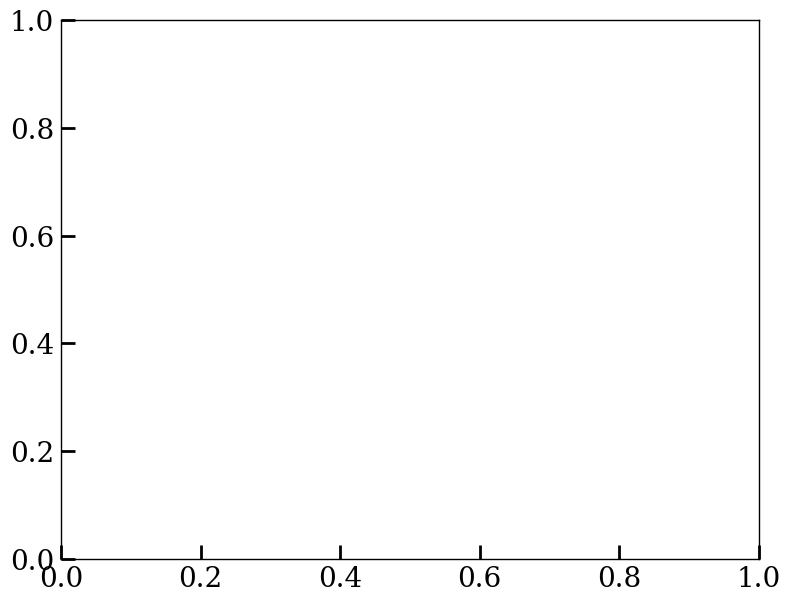

In [66]:
years = range(120) #range(1981, 2100, 5)
domain = 'd02'
sidemasks = xr.open_dataset(f'masks_{domain}_sn.nc')
t2_meananom = xr.open_dataset(f't2_{domain}_{bc}_meananom_annual.nc') #.resample(time = '1AS').sum(dim = 'time')
prec_meananom = xr.open_dataset(f'prec_{domain}_{bc}_meananom_annual.nc')# .resample(time = '1AS').sum(dim = 'time')
snow_meananom = xr.open_dataset(f'snow_{domain}_{bc}_meananom_annual.nc')# .resample(time = '1AS').sum(dim = 'time')
emask = xr.open_dataset(f'e1500_{domain}.nc')
emask_values = emask['HGT'].data
style = {'lee': '-',
         'wind': '--',
         'prec': 'darkblue',
         'temp': 'orchid'}

fig,ax = plt.subplots()

for sidename in ['lee', 'wind']:
    smask_values = sidemasks.sel(side = sidename).basin_mask.values
    mask = (emask_values & smask_values)
    c_t2 = np.nanmean(t2_meananom['t2'].where(mask), axis = (1,2))
    c_prec = np.nanmean(prec_meananom['prec'].where(mask), axis = (1,2))
    c_snow = np.nanmean(snow_meananom['snow'].where(mask), axis = (1,2))
    ax.plot(years, c_t2[0:-1], linestyle = style[sidename], color = style['temp'], label = f'temperature [K] {sidename}')
    ax.plot(years, c_prec[0:-1], linestyle = style[sidename],  color = style['prec'], label = f'precipitation [mm/d] {sidename}')
ax.legend()
plt.show()

<xarray.Dataset>
Dimensions:  (lat2d: 104, lon2d: 109)
Dimensions without coordinates: lat2d, lon2d
Data variables:
    t2       (lat2d, lon2d) float32 ...

In [76]:
## by huc2
lat_array = coords2['XLAT'].data
lon_array = coords2['XLONG'].data 
elevation = coords2['HGT'][0].data
sidenames = ['lee', 'wind']
regionmasks = sidemasks

swe = snowdata_mean

snow_by_elev_bin = {}
swei_by_elev_bin = {}
prec_by_elev_bin = {}
temp_by_elev_bin = {}
area_by_elev_bin = {}
for subregion in sidenames:
    snow_by_elev_bin[subregion] = []
    area_by_elev_bin[subregion] = []
elevation_min = elevation.min()
elevation_max = elevation.max()
elevation_step = 200
elevation_data= elevation.data
elevation_bins = np.arange(elevation_min, elevation_max + elevation_step, elevation_step)

## elevation mask
mask = np.logical_and(elevation_data >= elevation_bins[:-1, np.newaxis, np.newaxis], elevation_data < elevation_bins[1:, np.newaxis, np.newaxis])

for i in range(12):
    y1 = 1980 + (10 * i)
    day_start = f"{y1}-10-01"
    day_end = f"{y1+10}-09-30"
    swe_sorted = swe #.sortby('year')
    day_start = np.datetime64(day_start)
    day_end = np.datetime64(day_end)

    # Select the subset of the dataset within the day range
    #subset = swe_sorted.sel(time=slice(day_start, day_end)).mean(dim = 'time')
    subset = swe_sorted.sel(year = slice(y1, y1+10)).mean(dim = 'year')
    # Take the average of the "swe" variable across all days in the subset
    max_swe = subset['snow'].values #["swe"].max(dim="day").compute()

    for j,sidename in enumerate(sidenames):
        regmask = sidemasks.sel(side = sidename).basin_mask.values
        snow = (max_swe * regmask * mask).sum(axis = (1,2))
        area = mask.sum(axis = (1,2))
        snow_by_elev_bin[sidename].append(snow)
        area_by_elev_bin[sidename].append(area)

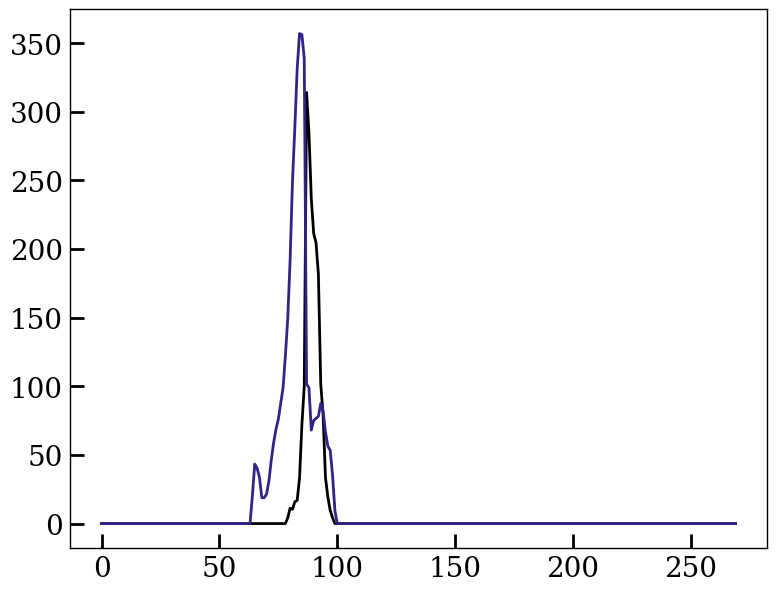

In [163]:
fig,ax = plt.subplots()
for j,sidename in enumerate(sidenames):
    regmask = sidemasks.sel(side = sidename).basin_mask.values
    profile = np.nanmean((elevation * regmask), axis= 0)
    ax.plot(profile)

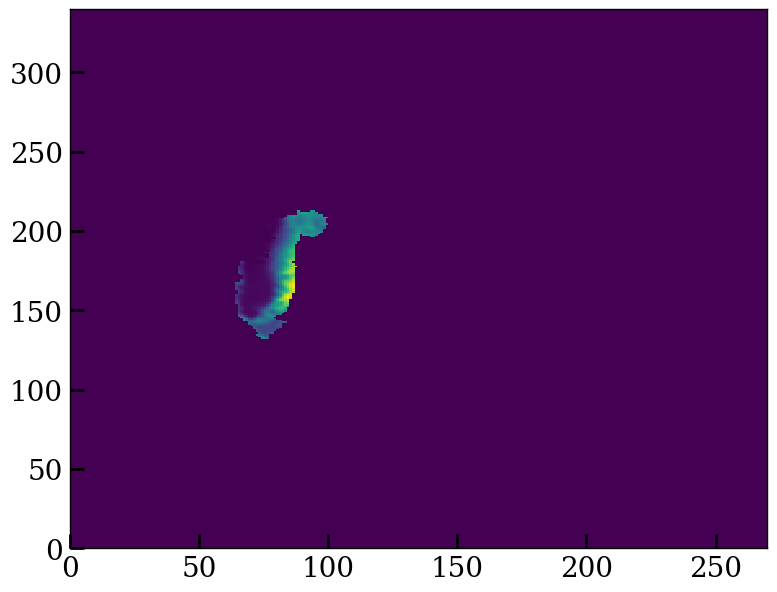

In [161]:
plt.pcolormesh(elevation * regmask)

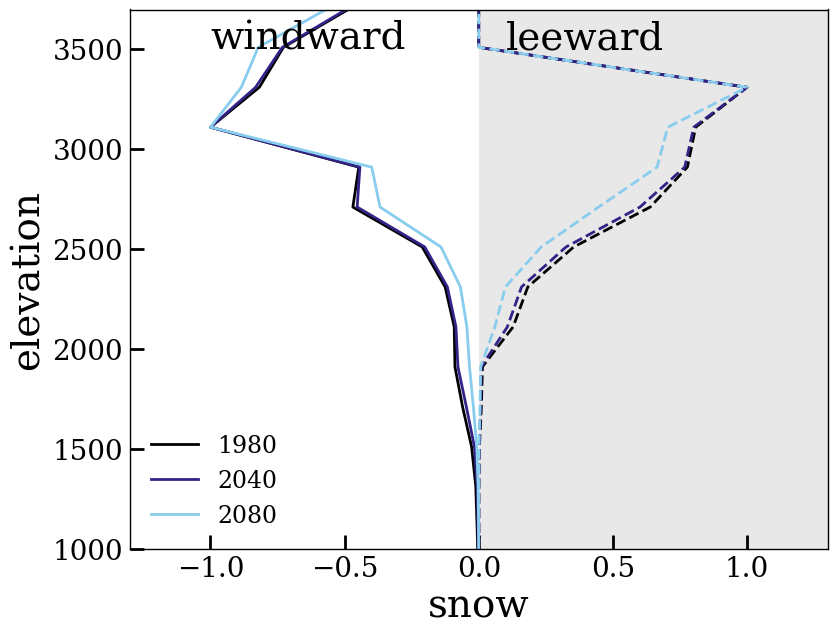

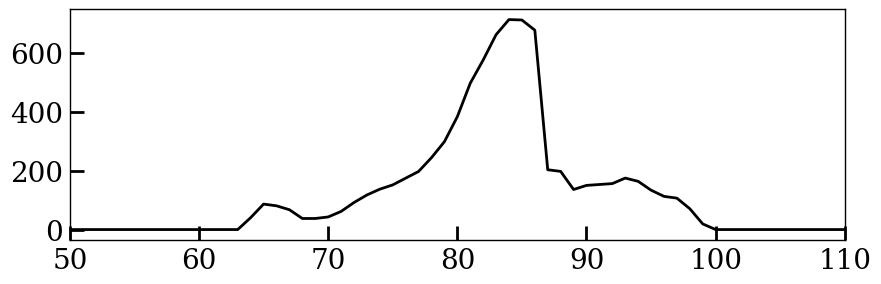

In [79]:
fig,ax = plt.subplots(1)
ax.axvspan(0, 4, facecolor='lightgray', alpha=0.5)
ax.axvspan(-4, 0, facecolor='white', alpha=0.5)
yrs = [0,6,10]
style = {'lee': '--',
         'wind': '-',
         'prec': 'darkblue',
         'temp': 'orchid'}
yrcolors = ["black", "#332288","#88CCEE","#44AA99","#117733",
            "#999933","#DDCC77","#CC6677","#882255","#AA4499","brown","#fd3c06","gray"]
profs = []
for i, subregion in enumerate(sidenames):
    regmask = sidemasks.sel(side = sidename).basin_mask.values
    profile = np.nanmean((elevation * regmask), axis= 0)
    profs.append(profile)
    snowdata = np.array(snow_by_elev_bin[subregion]) / np.array(area_by_elev_bin[subregion])
    for j in range(3):
        data = (snowdata[yrs[j]]) 
        label = None
        if subregion == 'wind': 
            data = -data
            label = yrs[j] * 10  +1980
        ax.plot(data / np.abs(np.nanmax(np.abs(data))) , 
                elevation_bins[1:], linestyle =style[subregion], 
                color = yrcolors[j] ,label =  label)
ax.set_ylabel('elevation')
ax.set_xlabel('snow')
ax.set_ylim((1000,3700))
ax.set_xlim((-1.3,1.3))
ax.text(-1, 3500, 'windward')
ax.text(0.1,3500, 'leeward')
ax.legend()
plt.show()
profile = profs[0] + profs[1]
fig,ax = plt.subplots(figsize = (10,3))
ax.plot(profile)
ax.set_xlim((50,110))
plt.show()


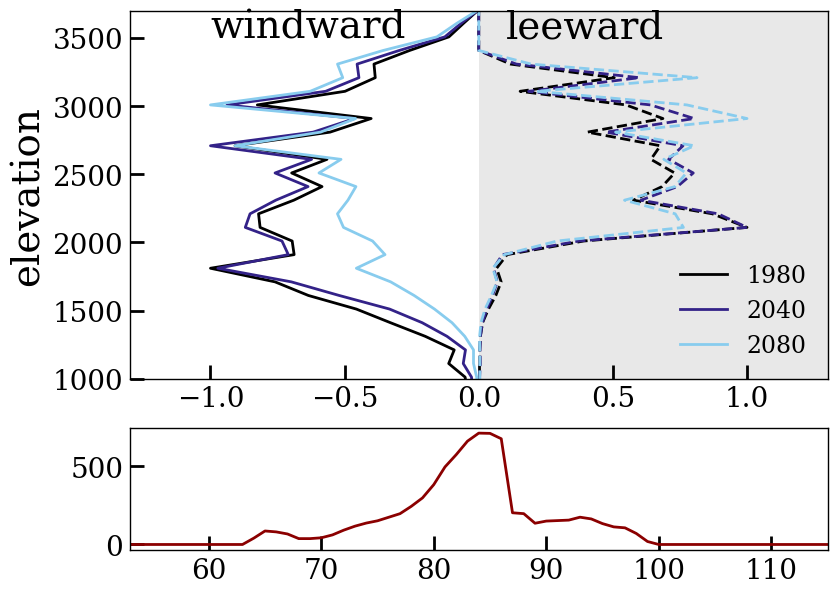

In [176]:
f, (ax, a1) = plt.subplots(2, 1, height_ratios=[3,1])
ax.axvspan(0, 4, facecolor='lightgray', alpha=0.5)
ax.axvspan(-4, 0, facecolor='white', alpha=0.5)
yrs = [0,6,10]
style = {'lee': '--',
         'wind': '-',
         'prec': 'darkblue',
         'temp': 'orchid'}
yrcolors = ["black", "#332288","#88CCEE","#44AA99","#117733",
            "#999933","#DDCC77","#CC6677","#882255","#AA4499","brown","#fd3c06","gray"]
profs = []
for i, subregion in enumerate(sidenames):
    regmask = sidemasks.sel(side = sidename).basin_mask.values
    profile = np.nanmean((elevation * regmask), axis= 0)
    profs.append(profile)
    snowdata = snow_by_elev_bin[subregion]
    for j in range(3):
        data = (snowdata[yrs[j]]) 
        label = None
        if subregion == 'wind': 
            data = -data
            label = yrs[j] * 10  +1980
        ax.plot(data / np.abs(np.nanmax(np.abs(data))) , 
                elevation_bins[1:], linestyle =style[subregion], 
                color = yrcolors[j] ,label =  label)
ax.set_ylabel('elevation')
ax.set_ylim((1000,3700))
ax.set_xlim((-1.3,1.3))
ax.text(-1, 3500, 'windward')
ax.text(0.1,3500, 'leeward')
ax.legend()
profile = profs[0] + profs[1]
a1.plot(profile, color = 'darkred')
a1.set_xlim((53,115))
plt.show()


In [21]:
## elevation CDF
fig,ax = plt.subplots()

for sidename in ['lee', 'wind']:
    smask_values = sidemasks.sel(side = sidename).basin_mask.values
    mask = (emask_values & smask_values)
    c_t2 = np.nanmean(t2_meananom['t2'].where(mask), axis = (1,2))
    c_prec = np.nanmean(prec_meananom['prec'].where(mask), axis = (1,2))
    c_snow = np.nanmean(snow_meananom['snow'].where(mask), axis = (1,2))
    ax.plot(years, c_t2[0:-1], linestyle = style[sidename], color = style['temp'], label = f'temperature [K] {sidename}')
    ax.plot(years, c_prec[0:-1], linestyle = style[sidename],  color = style['prec'], label = f'precipitation [mm/d] {sidename}')
ax.legend()
plt.show()

In [ ]:
years = range(1980,2101, 5)

t2_meananom_a = xr.open_dataset(f't2_{domain}_{bc}_meananom_annual.nc')
prec_meananom_a = xr.open_dataset(f'prec_{domain}_{bc}_meananom_annual.nc')
snow_meananom_a = xr.open_dataset(f'snow_{domain}_{bc}_meananom_annual.nc')

emask = xr.open_dataset(f'e1500_{domain}.nc')
emask_values = emask['HGT'].data
fig,ax = plt.subplots()
warm = allcateg_sum['tas_cond']
dry = allcateg_sum['pr_cond']
drought = allcateg_sum['swei_cond']

colors = {'lee': 'red', 'wind': 'black'}
for sidename in ['lee', 'wind']:
    smask_values = sidemasks.sel(side = sidename).basin_mask.values
    mask = (emask_values & smask_values)
    c_t2 = np.nanmean(t2_meananom_a['t2'].where(drought).where(mask), axis = (1,2))
    c_prec = np.nanmean(prec_meananom_a['prec'].where(drought).where(mask), axis = (1,2))
    c_swei = np.nanmean(allswei_mean['swei'].where(mask), axis = (1,2))
    tmp = drought.where(mask).load()
    tmp2 = np.nanmean(tmp, axis= (1,2))
    grouped_tmp = tmp2[0:120].reshape(-1, 5)
    # Calculate the mean for each group
    mean_per_group = np.mean(grouped_tmp, axis=1)

    ax.plot(c_t2[0:-1], c_prec[0:-1], ':', label = f'{domain} {sidename}', color = colors[sidename])
    #ax.scatter(c_t2[0:-1],c_prec[0:-1], s = mean_per_group)


# Set logarithmic scales on both axes
ax.set_xscale('symlog')
ax.set_yscale('symlog')

# Set the limits of the axes to make them symmetrical around zero
#ax.set_xlim([-1e1, 1e1])
# ax.set_ylim([-1e1, 1e1])

# Add grid lines at zero on both axes
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Warm')
ax.set_ylabel('Dry')
ax.legend()
plt.show()

/glade/scratch/mcowherd/ipykernel_85275/4028388810.py:10: RuntimeWarning: Mean of empty slice
  ax[0].pcolormesh(np.nanmean(data[-30:], axis = 0),  vmin = 0, vmax = 6)
/glade/scratch/mcowherd/ipykernel_85275/4028388810.py:10: RuntimeWarning: Mean of empty slice
  ax[0].pcolormesh(np.nanmean(data[-30:], axis = 0),  vmin = 0, vmax = 6)


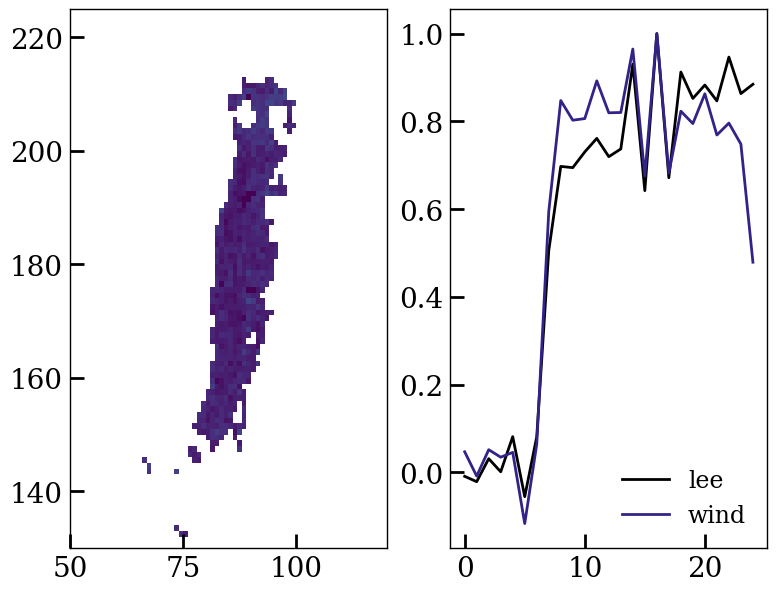

In [44]:
fig,ax = plt.subplots(1,2)
colors = {'lee': 'Blues', 'wind': 'Reds'}

datas = {}
for sidename in ['lee', 'wind']:
    smask_values = sidemasks.sel(side = sidename).basin_mask.values
    mask = (emask_values & smask_values)
    data = (allcateg_sum['pr_cond'] & allcateg_sum['swei_cond'] & ~allcateg_sum['tas_cond']).where(mask)
    datas[sidename] = data
    ax[0].pcolormesh(np.nanmean(data[-30:], axis = 0),  vmin = 0, vmax = 6)
    #ax[0].pcolormesh((snow_meananom['snow'].where(mask)[-1]), cmap = colors[sidename])
    ts = np.nanmean(prec_meananom['prec'].where(mask), axis = (1,2))
    ax[1].plot(ts/np.nanmax(ts), label = sidename)
ax[1].legend()
ax[0].set_xlim((50,120))
ax[0].set_ylim((130,225))
plt.show()

[]

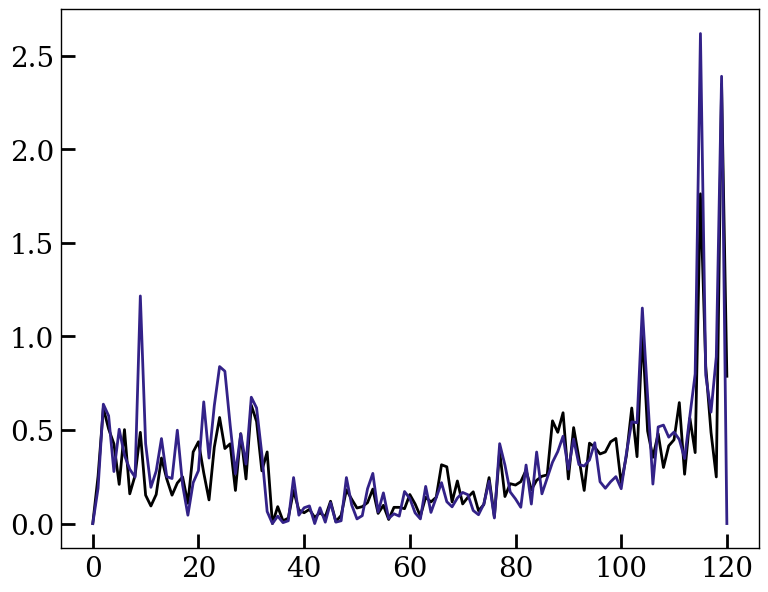

In [45]:
fig,ax=plt.subplots()
for key in ['lee', 'wind']:
    data = datas[key]
    ax.plot(np.nanmean(data, axis = (1,2)))
plt.plot()

In [15]:
tmp = precdata.resample(time='5AS').mean(dim='time')

In [16]:
diffs = tmp['prec'] - np.nanmean(tmp['prec'][0:10], axis = 0)

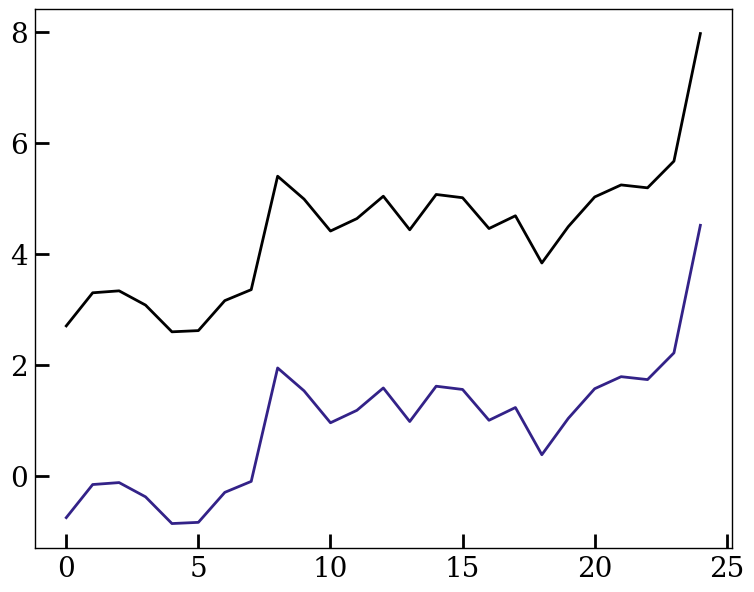

In [17]:
fig,ax=plt.subplots()
ax.plot(np.nanmean(tmp['prec'].where(mask), axis = (1,2)))
ax.plot(np.nanmean(diffs.where(mask), axis = (1,2)))
plt.show()

/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/glade/scratch/mcowherd/ipykernel_47180/3558373176.py:30: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should l

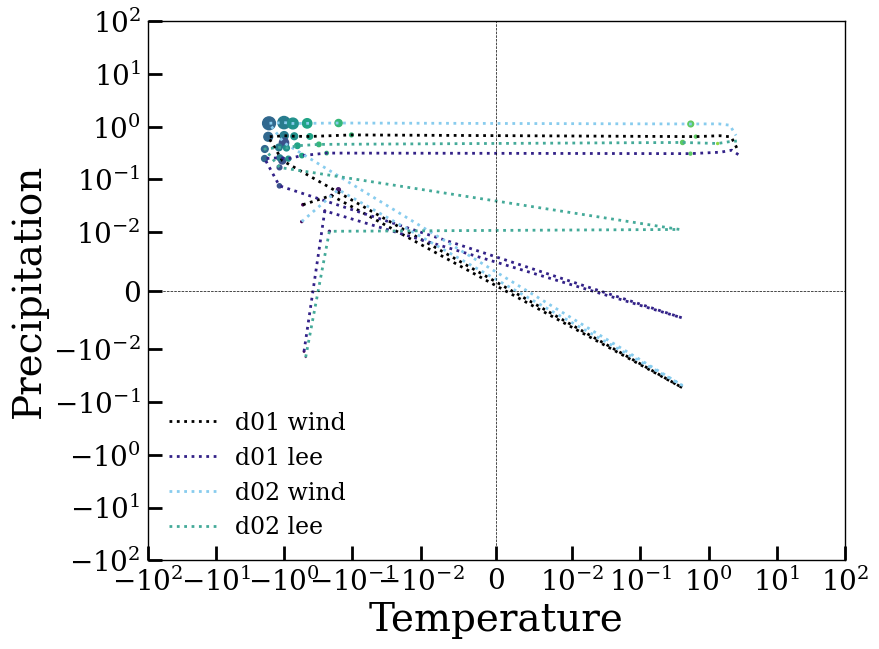

In [30]:
years= range(1980, 2110, 10)
fig, ax = plt.subplots()
for domain in ts.keys():
    for sidename in ts[domain].keys():
        datasets_snow = []
        datasets_prec = []
        datasets_t2 = []
        for gcm in ts[domain][sidename].keys():
            datasets_snow.append(ts[domain][sidename][gcm]['snow'])
            datasets_prec.append(ts[domain][sidename][gcm]['prec'])
            datasets_t2.append(ts[domain][sidename][gcm]['t2'])
        
        c_snow = xr.concat(datasets_snow, dim='gcm').mean(dim = 'gcm')
        c_prec = xr.concat(datasets_prec, dim='gcm').mean(dim = 'gcm')
        c_t2 = xr.concat(datasets_t2, dim='gcm').mean(dim = 'gcm')
        
        ax.plot(c_t2, c_prec, ':', label = f'{domain} {sidename}')
        ax.scatter(c_t2,c_prec, s = c_snow, c= years)
        

# Set logarithmic scales on both axes
ax.set_xscale('symlog', linthresh=0.01)
ax.set_yscale('symlog', linthresh=0.01)

# Set the limits of the axes to make them symmetrical around zero
ax.set_xlim([-1e2, 1e2])
ax.set_ylim([-1e2, 1e2])

# Add grid lines at zero on both axes
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

ax.set_xlabel('Temperature')
ax.set_ylabel('Precipitation')
ax.legend()
plt.show()